# Ejercicio 2 (3 puntos)

Diseña e implementa una red neuronal feedforward para predecir el nivel de riesgo (RiskLevel) utilizando las demás columnas del conjunto de datos proporcionado en el archivo 'maternal_health_risk_data_set.csv'. Sigue las siguientes indicaciones:

1. Divide el conjunto de datos en:

- 70% para entrenamiento.

- 15% para validación.

- 15% para prueba (test).

2. Utiliza la clase DataLoader para cargar los datos en minibatches.

3. Diseña la red neuronal con las siguientes características:

- Dos capas ocultas con 64 y 32 neuronas, respectivamente.

- Una función de pérdida adecuada para el problema.

- El optimizador Adam.

4. Durante el entrenamiento:

- Muestra la evolución de la función de pérdida y la precisión (accuracy).

- Entrena la red durante 3 epochs.

5. Evalúa el modelo final utilizando el conjunto de prueba (test) y reporta la precisión (accuracy) obtenida.

---

# Configuración y Visualización del Entorno

## Configuración de las Rutas de Importación

Se añade el directorio padre (..) al path (sys.path), lo que permite al entorno de Python acceder a módulos o paquetes ubicados en directorios superiores al actual. Esto es útil para poder importar scripts o paquetes personalizados sin tener que mover ficheros o el directorio de trabajo.

In [91]:
import sys
sys.path.insert(0, '..')

## Verificación de las Versiones de los Paquetes

Se utiliza la función check_packages() para verificar que los paquetes y sus respectivas versiones indicadas en el diccionario 'd' estén instalados correctamente dentro del entorno. Este paso es importante para verificar la compatibilidad de cada paquete para poder evitar errores por diferencia de versión.

In [92]:
from python_environment_check import check_packages
d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'mlxtend' : '0.19.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
    'torch': '1.9.0',
    'torchvision': '0.9.0',
    'tensorboard': '2.7.0',
    'pytorch_lightning': '1.5.0',
    'torchmetrics': '0.6.2'
}
check_packages(d)

[OK] numpy 1.26.4
[OK] scipy 1.8.0
[OK] mlxtend 0.23.1
[OK] matplotlib 3.5.1
[OK] sklearn 1.5.2
[OK] pandas 2.2.2
[OK] torch 2.5.1+cpu
[OK] torchvision 0.20.1+cpu
[OK] tensorboard 2.18.0
[OK] pytorch_lightning 2.4.0
[OK] torchmetrics 1.6.0


## Importación de Paquetes

Se importan los paquetes esenciales para analizar y visualizar datos: numpy para cálculos numéricos, pandas para manipular datos y matplotlib.pyplot para visualizar gráficos, entre otros.

In [93]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

---

# Código Fuente

In [94]:
df = pd.read_csv('maternal_health_risk_data_set.csv')
df.shape

(1014, 7)

In [95]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


Como se puede observar, el dataset está compuesto por 6 características y un resultado que indica el tipo de riesgo.

Como el resultado no es binario, se optimiza para que pueda ser usado con multiclases y además, se usa hot encoding para convertir los resultados en valores numéricos.

In [96]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
for i in range(len(y)):
    if y[i] == 'high risk':
        y[i] = 0
    elif y[i] == 'mid risk':
        y[i] = 1
    elif y[i] == 'low risk':
        y[i] = 2

**Conversión del Dataset a PyTorch**

Se dividen los datos en training, validation y test para poder realizar el entrenamiento del modelo, quedándonos con un 70% del dataset de entrenamiento, un 15% para validación y el 15% restante para prueba (test). 

In [97]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=0
)

Una vez hecho esto, se normalizan los datos de las columnas numéricas para poder utililzarlos en el entrenamiento de la red neuronal.

In [98]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(np.array(y_train, dtype=np.int64))
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

**Creación de la Red Neuronal**

In [99]:
class Model(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Softmax(dim=1)(x)
        return x

**Configuración del Entrenamiento de la Red Neuronal**

In [100]:
input_size = X_train_norm.shape[1]
model = Model(input_size)

learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Entrenamiento de la Red Neuronal**

Se establece el número de épocas a 3 (num_epochs=3) para ver cómo se va entrenando la red neurona y obtener una mayor y mejor precisión.

In [101]:
num_epochs = 3
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.mean()
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

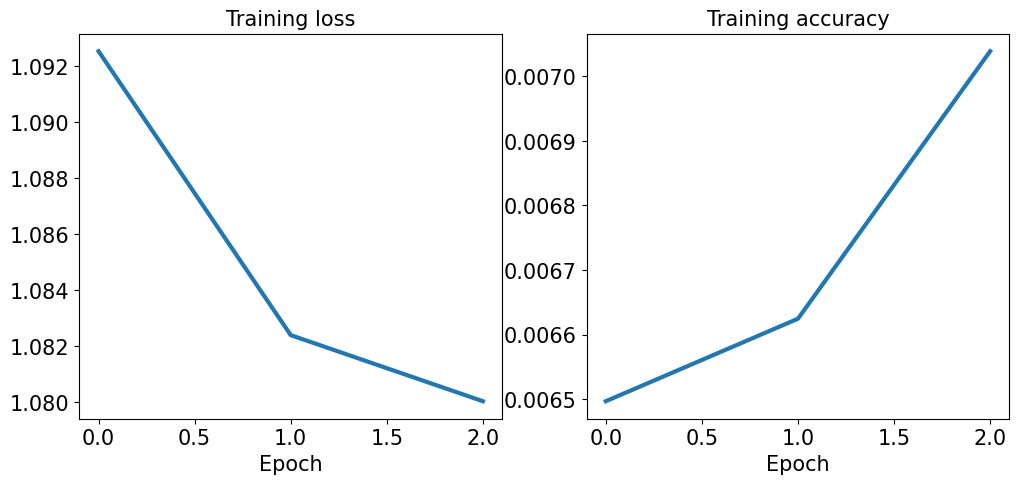

In [102]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [103]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(np.array(y_test, dtype=np.int64))
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.3987


Como se puede observar, la precisión obtenida por parte del conjunto de prueba (test) es del 40% aproximadamente.

---

# Convertir Jupyter Notebook a Fichero Python

In [104]:
! python .convert_notebook_to_script.py --input answer2.ipynb --output answer2.py

[NbConvertApp] Converting notebook answer2.ipynb to script
[NbConvertApp] Writing 6787 bytes to answer2.py
